#### Summation von n zahlen

In [59]:
def sum_it(n):
    s = 0
    a = [i+1 for i in range(n)]
    for i in range(n):
        s = s + a[i]
    return s

In [60]:
n = 10
sum_it(n)

55

In [61]:
test = 1000000
%timeit -r 20 -n 20 sum_it(test)

64.7 ms ± 3.23 ms per loop (mean ± std. dev. of 20 runs, 20 loops each)


#### Parallelisierung durch Blöcke

In [62]:
import multiprocessing as mp
import numpy as np

In [63]:
def parallel_sum(a, my_rank, segment):
    summe = 0
    for i in range(segment):
        summe += a[i + my_rank * segment]
    return summe

def sum_par_1(n, p=None):
    if p is None:
        p = int(np.ceil(np.log2(n)))
    a = [i+1 for i in range(n)]
    segment = n//p
    pool = mp.Pool(processes=p)
    summen = pool.starmap(parallel_sum, [(a, i, segment) for i in range(p)])
    pool.close()
    pool.join()
    return sum(summen)

In [64]:
n = 10
sum_par_1(n, 2)

55

In [65]:
test = 1000000 # 1 mil
p = 4
%timeit -r 20 -n 20 sum_par_1(test, p)

308 ms ± 3.52 ms per loop (mean ± std. dev. of 20 runs, 20 loops each)


#### Berechnung durch Formel

In [91]:
def formel(n):
    return (n*(n+1))/2
test = 1000000 # 1 mil
%timeit -r 100 -n 20 formel(test)

107 ns ± 49 ns per loop (mean ± std. dev. of 100 runs, 20 loops each)


In [67]:
test = 10
formel(test)

55.0

In [68]:
test = 1000000 # 1 mil
%timeit -r 100 -n 100 formel(test)

The slowest run took 291.63 times longer than the fastest. This could mean that an intermediate result is being cached.
390 ns ± 2.62 µs per loop (mean ± std. dev. of 100 runs, 100 loops each)


#### Berechnung durch Baum-Reduktion

In [69]:
def tree_reduction(n):
    tree = [i+1 for i in range(n)]
    
    while n > 1:
        # Neue Ebene im Baum erstellen
        new_n = (n + 1) // 2
        new_tree = [0] * new_n
        
        # Elemente der neuen Ebene berechnen
        for i in range(0, n, 2):
            j = i + 1
            if j < n:
                new_tree[i//2] = tree[i] + tree[j]
            else:
                new_tree[i//2] = tree[i]
        
        # Neue Ebene in den Baum einfügen
        tree = new_tree
        n = new_n
    
    # Rückgabe der Gesamtsumme
    return tree[0]

In [70]:
x = 10
tree_reduction(x)

55

In [71]:
# 1 tril
test = 1000000
%timeit -r 20 -n 20 tree_reduction(test)

104 ms ± 6.42 ms per loop (mean ± std. dev. of 20 runs, 20 loops each)


#### Berechnung durch Threading

In [72]:
import threading

def threaded_reduction(n, num_threads=None):
    if num_threads is None:
        num_threads = int(np.ceil(np.log2(n)))
    arr = [i+1 for i in range(n)]
    chunk_size = (n + num_threads - 1) // num_threads
    chunks = [arr[i:i+chunk_size] for i in range(0, n, chunk_size)]
    chunk_sums = [0] * len(chunks)
    
    def reduce_chunk(chunk_idx):
        chunk_sum = 0
        for x in chunks[chunk_idx]:
            chunk_sum += x
        chunk_sums[chunk_idx] = chunk_sum
    
    threads = [threading.Thread(target=reduce_chunk, args=(i,))
               for i in range(len(chunks))]
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()
    
    total_sum = 0
    for chunk_sum in chunk_sums:
        total_sum += chunk_sum
    
    return total_sum

In [73]:
x = 10
threaded_reduction(x, 2)

55

In [74]:
# 1 tril
test = 1000000
p = 4
%timeit -r 20 -n 20 threaded_reduction(test, p)

104 ms ± 3.6 ms per loop (mean ± std. dev. of 20 runs, 20 loops each)


#### Plot

In [75]:
import matplotlib.pyplot as plt
import time

In [80]:
f1 = sum_it
f2 = sum_par_1
f3 = formel
f4 = tree_reduction
f5 = parallel_sum

In [83]:
def time_function(f, n):
    start = time.time()
    print(f.__name__)
    f(n)
    return time.time() - start

In [86]:
arr = [10**i for i in range(1, 9)]
timed = [time_function(f, n) for n in arr for f in [f1, f2, f3, f4, f5]]

sum_it
sum_par_1


TypeError: parallel_sum() takes from 1 to 2 positional arguments but 3 were given

In [ ]:
best = [min(timed[i*5:i*5+5]) for i in range(len(arr))]

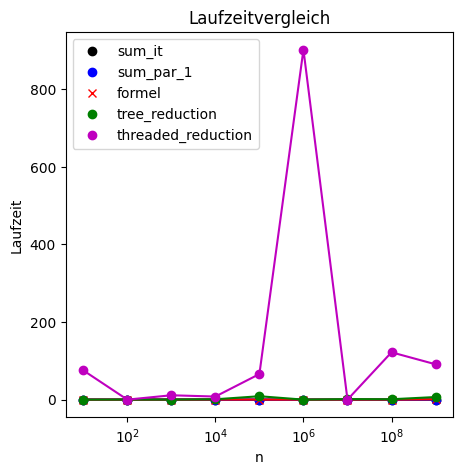

In [ ]:
fig = plt.figure(figsize=(5, 5))
plt.title('Laufzeitvergleich')
plt.plot(arr, timed[:len(arr)], 'ko', label='sum_it')
plt.plot(arr, timed[:len(arr)], 'k-')
plt.plot(arr, timed[len(arr):len(arr)*2], 'bo', label='sum_par_1')
plt.plot(arr, timed[len(arr):len(arr)*2], 'b-')
plt.plot(arr, timed[len(arr)*2:len(arr)*3], 'rx', label='formel')
plt.plot(arr, timed[len(arr)*2:len(arr)*3], 'r-')
plt.plot(arr, timed[len(arr)*3:len(arr)*4], 'go', label='tree_reduction')
plt.plot(arr, timed[len(arr)*3:len(arr)*4], 'g-')
plt.plot(arr, timed[len(arr)*4:len(arr)*5], 'mo', label='threaded_reduction')
plt.plot(arr, timed[len(arr)*4:len(arr)*5], 'm-')
plt.xlabel('n')
plt.ylabel('Laufzeit')
plt.legend()
plt.xscale('log')
plt.savefig('laufzeitvergleich.png')

#### Andre Code

In [ ]:
import multiprocessing
import mmap
import numpy as np
import time
import sys

start_time = time.time()

n = 2**3
h = round(np.log2(n))
length = 2**(h+1)-1
manager = multiprocessing.Manager()
w = multiprocessing.Array('f',length)
lock = multiprocessing.Lock()

def sumNodes(args):
    global w,h
    l, i = args
    sourceNodeBase = 2**(h+1) - 2**(h-(l-1))
    targetNodeBase = 2**(h+1) - 2**(h-l)
    k = i - sourceNodeBase + 2
    m = (k-(k % 2))/2 - 1
    q = sourceNodeBase + k-2
    targetNode = int(targetNodeBase + m)
    with lock:
        w[targetNode] = w[targetNode] + w[q]
        print(f"w[{targetNode}] = w[{targetNode}] + w[{q}] -> {w[targetNode]}")
        print(w[:])
    

# test data
for i in range(n):
    w[i] = i+1
print('Array', w[:])
for l in range(0,h):
    with multiprocessing.Pool(processes=10) as pool:
        args = [(l, i) for i in range(int(n/(2**l)))]
        pool.map(sumNodes, args)
    print(int(n/(2**l)))
print(w[-1])

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to execute the code: {elapsed_time} seconds")

Array [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
w[8] = w[8] + w[0] -> 1.0
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
w[8] = w[8] + w[1] -> 3.0
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
w[9] = w[9] + w[2] -> 3.0
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0]
w[9] = w[9] + w[3] -> 7.0
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 3.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0]
w[10] = w[10] + w[4] -> 5.0
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 3.0, 7.0, 5.0, 0.0, 0.0, 0.0, 0.0]
w[10] = w[10] + w[5] -> 11.0
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 3.0, 7.0, 11.0, 0.0, 0.0, 0.0, 0.0]
w[11] = w[11] + w[6] -> 7.0
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 3.0, 7.0, 11.0, 7.0, 0.0, 0.0, 0.0]
w[11] = w[11] + w[7] -> 15.0
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 3.0, 7.0, 11.0, 15.0, 0.0, 0.0, 0.0]
8
w[8] = w[8] + w[0] -> 4.0
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 4.0, 7.0, 11.0, 15.

In [90]:
import multiprocessing

def block_sum(start, end):
    return sum(range(start, end))

def parallel_sum(n, num_blocks=8):
    pool = multiprocessing.Pool(processes=num_blocks)
    block_size = n // num_blocks
    results = [pool.apply_async(block_sum, (i*block_size+1, (i+1)*block_size+1)) for i in range(num_blocks)]
    pool.close()
    pool.join()
    return sum(result.get() for result in results)

test = 1000000
p = 4
%timeit -r 100 -n 20 parallel_sum(test, p)

43.1 ms ± 402 µs per loop (mean ± std. dev. of 100 runs, 20 loops each)


In [ ]:
import multiprocessing
from tqdm import tqdm

def block_sum(start, end):
    return sum(range(start, end))

def parallel_sum2(n, num_blocks):
    pool = multiprocessing.Pool(processes=num_blocks)
    block_size = n // num_blocks
    results = []
    for i in range(num_blocks):
        start = i * block_size + 1
        end = (i+1) * block_size + 1
        result = pool.apply_async(block_sum, args=(start, end))
        results.append(result)
    pool.close()

    # Fortschrittsanzeige
    with tqdm(total=num_blocks) as pbar:
        while results:
            for i, result in enumerate(results):
                if result.ready():
                    pbar.update(1)
                    results.pop(i)
                    break

    pool.join()
    return sum(result.get() for result in results)

n = 100000000000
num_blocks = 64
result = parallel_sum2(n, num_blocks)
print(result)

100%|██████████| 8/8 [05:25<00:00, 40.64s/it] 

0
